In [47]:
import os, shutil, sys, random, cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from random import choice

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
dataset_dividido_folder = 'brain_tumor_dataset_dividido/'

treino_folder = 'treino/'
teste_folder = 'teste/'
#validacao_folder = 'validacao/'

dataset_dividido_folder_treino = dataset_dividido_folder + treino_folder
dataset_dividido_folder_teste = dataset_dividido_folder + teste_folder
#dataset_dividido_folder_validacao = dataset_dividido_folder + validacao_folder

# Data Augmentation

In [49]:
datagen_treino = ImageDataGenerator(rescale = 1./255,
                                    brightness_range=(0.7, 1.3),
                                    vertical_flip=True,
                                    horizontal_flip=True,
                                    validation_split = 0.25)

#datagen_validacao = ImageDataGenerator(rescale = 1./255)
datagen_teste = ImageDataGenerator(rescale = 1./255)

In [50]:
seed = 123

dados_treino = datagen_treino.flow_from_directory(
    dataset_dividido_folder_treino,
    target_size = (150,150),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode="binary",
    subset='training',
    seed = seed)



dados_validacao = datagen_treino.flow_from_directory(
    dataset_dividido_folder_treino,
    target_size = (150,150),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode="binary",
    subset='validation',
    seed = seed)

'''dados_validacao = datagen_validacao.flow_from_directory(
    dataset_dividido_folder_validacao,
    target_size = (150,150),
    color_mode = "grayscale",
    batch_size = 30,
    class_mode="binary",
    seed = seed)'''

dados_teste = datagen_teste.flow_from_directory(
    dataset_dividido_folder_teste,
    target_size = (150,150),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode = 'binary'
    )

print(dados_treino.class_indices)

Found 145 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Found 64 images belonging to 2 classes.
{'no': 0, 'yes': 1}


# Visualizar exemplo Data Augmentation

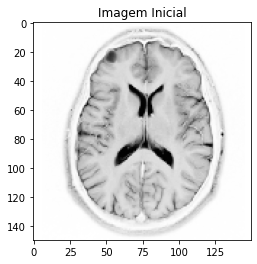

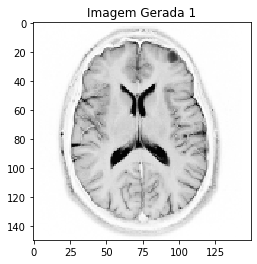

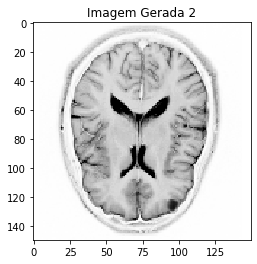

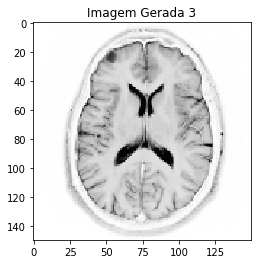

In [51]:
#.__getitem__(batch, max de 8)[atributos/class :0 -> atributos, 1 -> class][imagens, max de 29, batch_size 30]
img = dados_treino.__getitem__(0)[0][1]
x = image.img_to_array(img)
plt.figure(0)
plt.imshow(np.squeeze(x, axis=2), cmap = "Greys")
plt.title('Imagem Inicial')
x = x.reshape((1,) + x.shape)
i = 1
#.flow -> real time data augmentation.
for batch in datagen_treino.flow(x, batch_size=1):
    plt.figure(i)
    plt.title('Imagem Gerada ' + str(i))
    imgplot = plt.imshow(image.array_to_img(batch[0]), cmap = "Greys", interpolation = "nearest")
    i += 1
    if i % 4 == 0:
        break

plt.show()

# Criar Modelo

In [52]:
#Foi acrescentado ReduceLROnPlateau callback ao modelo.
#Aplicando ReduceLROnPlateau  reduz a taxa de aprendizagem por um fator de 2-10 quando o processo de aprendizagem estagna.
#O callback monitoriza o processo e se não houver melhorias em 'patience' epochs seguidas, a taxa de aprendizagem é reduzida.
#Reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patiente = 2, cooldown = 2, min_lr = 0.00001, verbose = 1)
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True)
callbacks = [checkpointer]#,Reduce_learning_rate]

In [53]:
def setup_model_dynamic(num_neurons, input_size, output_size, dropout_size, activation, activation_output, num_newLayers):
    model = Sequential()
    model.add(Conv2D(num_neurons,(3,3), input_shape = (150,150,1), activation = activation))
    model.add(MaxPooling2D(pool_size = (2,2)))
    for i in range(1, num_newLayers):
        model.add(Conv2D(num_neurons * 2,(3,3), activation = activation))
        model.add(MaxPooling2D(pool_size = (2,2)))
        if dropout_size > 0: model.add(Dropout(dropout_size))
    model.add(Flatten())
    model.add(Dropout(dropout_size))
    model.add(Dense(64, activation = activation))
    model.add(Dense(1, activation= activation_output))
    
    return model

#model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ['accuracy'])

In [54]:
def setup_compile_model(model, optimizer, dados_treino, dados_validacao, lr, loss, epochs, steps_per_epochs, metric):
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate = lr)
    elif optimizer == 'RMSprop':
        opt = tf.keras.optimizers.Rmsprop(learning_rate = lr)
    elif optimizer == 'sgd_momentum':
        opt = tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.9)
    else: opt = tf.keras.optimizers.Adam(learning_rate = lr)
    model.compile(loss = loss, optimizer = opt, metrics = ["accuracy"])  #['"' + metric + '"'])
    history = model.fit(dados_treino, steps_per_epoch = steps_per_epochs, epochs = epochs, validation_data = dados_validacao, callbacks = callbacks, verbose = 1)
    return model,history

In [55]:
def run_dnn(dados_treino, dados_validacao, dados_teste, num_iterations, verbose = True):
    best_accuracy = 0
    num_neuron = [64, 32]
    input_size = (150,150,1)
    output_size = 1
    dropouts = [0.2, 0.4, 0.5]
    metric = ['accuracy']
    activations = ['relu', 'tanh']
    activations_output = ['sigmoid']
    losses = ['binary_crossentropy']
    optimizers = [ 'adam', 'rmsprop', 'sgd_momentum']
    epoch = [30, 15, 20]
    steps_per_epochs = [5]
    learning_rates = [0.001, 0.0001]
    num_newLayers = [2,3,4]
    
    for i in range(num_iterations):
        num_neurons = choice(num_neuron)
        dropout = choice(dropouts)
        metrics = choice(metric)
        optimizer = choice(optimizers)
        activation = choice(activations)
        activation_output = choice(activations_output)
        loss = choice(losses)
        epochs = choice(epoch)
        steps_per_epoch = choice(steps_per_epochs)
        learning_rate = choice(learning_rates)
        num_newLayer = choice(num_newLayers)
        model = setup_model_dynamic(num_neurons, input_size, output_size, dropout, activation, activation_output, num_newLayer)
        model, history = setup_compile_model(model, optimizer,dados_treino, dados_validacao, learning_rate, loss, epochs, steps_per_epoch, metrics)
        val_loss, val_accuracy = model.evaluate(dados_teste, verbose = 0)
        
        if verbose:
            print("num_neurons\tDropout\tactivation\tactivation_output\tval_loss\tval_accuracy\n")
            print(num_neurons, "\t", dropout, "\t", "\t", activation, "\t", activation_output,"\t", val_loss, "\t", val_accuracy)
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_configurations = (num_neurons, dropout, activation, activation_output, optimizer, loss, epochs, steps_per_epoch, learning_rate, metrics, num_newLayer)
    print("Best Accuracy: ", best_accuracy) 
    print("Configurations of model: Nª neurons: " + str(best_configurations[0]) + " dropout: "+ str(best_configurations[1]) + " activation: "+ str(best_configurations[2]) + " activation_output: "+ str(best_configurations[3]) + " activation_output: "+ str(best_configurations[4]) + " loss: "+ str(best_configurations[5]) + " epochs: " + str(best_configurations[6]) + " steps_per_epoch: " + str(best_configurations[7])+ " learning rate: " + str(best_configurations[8]) + " metric: " + str(best_configurations[9]) + " num_newLayers: " + str(best_configurations[10]) )
    return best_configurations

In [56]:
best_configurations = run_dnn(dados_treino, dados_validacao, dados_teste, 30)

Epoch 1/30
5/5 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.5793
Epoch 00001: val_accuracy improved from -inf to 0.61702, saving model to best_weights.hdf5
5/5 [==============================] - 1s 255ms/step - loss: 0.6864 - accuracy: 0.5793 - val_loss: 0.6531 - val_accuracy: 0.6170
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.6207
Epoch 00002: val_accuracy did not improve from 0.61702
5/5 [==============================] - 1s 207ms/step - loss: 0.6668 - accuracy: 0.6207 - val_loss: 0.6340 - val_accuracy: 0.6170
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.6207
Epoch 00003: val_accuracy improved from 0.61702 to 0.65957, saving model to best_weights.hdf5
5/5 [==============================] - 1s 219ms/step - loss: 0.6471 - accuracy: 0.6207 - val_loss: 0.6273 - val_accuracy: 0.6596
Epoch 4/30
5/5 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.6345
Epoch

In [57]:
best_model = setup_model_dynamic(best_configurations[0], 1, 1, best_configurations[1], best_configurations[2], best_configurations[3], best_configurations[10])
best_model, history = setup_compile_model(best_model, best_configurations[0], dados_treino, dados_validacao, best_configurations[8], best_configurations[5], best_configurations[6], best_configurations[7], best_configurations[9])
scores = best_model.evaluate(dados_teste, verbose = 0)
print("Accuracy: ", scores[1] * 100)

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 0.7743 - accuracy: 0.6552
Epoch 00001: val_accuracy did not improve from 0.93617
5/5 [==============================] - 1s 274ms/step - loss: 0.7743 - accuracy: 0.6552 - val_loss: 0.6537 - val_accuracy: 0.8936
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.7379
Epoch 00002: val_accuracy did not improve from 0.93617
5/5 [==============================] - 1s 245ms/step - loss: 0.6393 - accuracy: 0.7379 - val_loss: 0.5564 - val_accuracy: 0.6170
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.7379
Epoch 00003: val_accuracy did not improve from 0.93617
5/5 [==============================] - 1s 256ms/step - loss: 0.5658 - accuracy: 0.7379 - val_loss: 0.4455 - val_accuracy: 0.8936
Epoch 4/20
5/5 [==============================] - ETA: 0s - loss: 0.5316 - accuracy: 0.7310
Epoch 00004: val_accuracy did not improve from 0.93617
5/5 [====================

In [58]:
print(best_model.summary())

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_251 (Conv2D)          (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d_251 (MaxPoolin (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_252 (Conv2D)          (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_252 (MaxPoolin (None, 36, 36, 128)       0         
_________________________________________________________________
dropout_251 (Dropout)        (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_253 (Conv2D)          (None, 34, 34, 128)       147584    
_________________________________________________________________
max_pooling2d_253 (MaxPoolin (None, 17, 17, 128)     

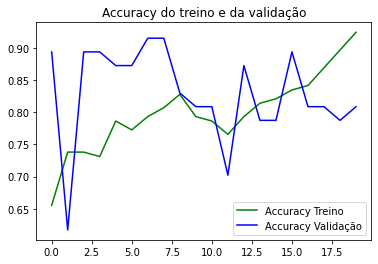

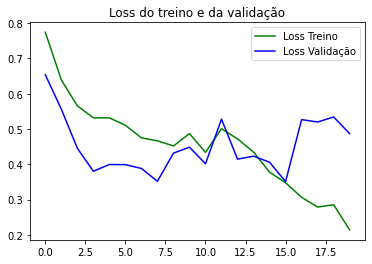

In [59]:
#Visualizar gráficos
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

#Gráfico Accuracy
plt.plot(epochs, accuracy, 'b', color = 'green', label = 'Accuracy Treino')
plt.plot(epochs, val_accuracy, 'b', label = 'Accuracy Validação')
plt.title('Accuracy do treino e da validação')
plt.legend()
plt.figure()

#Gráfico Loss
plt.plot(epochs, loss, 'b', color = 'green', label = 'Loss Treino')
plt.plot(epochs, val_loss, 'b', label = 'Loss Validação')
plt.title('Loss do treino e da validação')
plt.legend()
plt.show()

X: (150, 150, 1)
y: ()


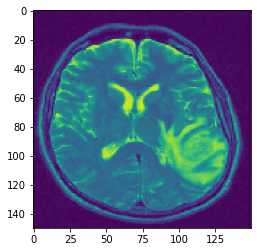

label: 1.0
antes do aumento de mais uma dimensão: (150, 150, 1)
depois do aumento de mais uma dimensão: (1, 150, 150, 1)
previsão: [[0.19471906]]
Classe prevista: [[0]]


In [60]:
def visualize_previsao(img, img_class):
    print("X:",img.shape)
    print("y:",img_class.shape)
    plt.imshow(np.squeeze(img, axis=2))
    plt.show()
    print("label:",img_class)
    print("antes do aumento de mais uma dimensão:",img.shape)
    imagem_tensor = np.expand_dims(img, axis=0)
    print("depois do aumento de mais uma dimensão:",imagem_tensor.shape)
    print("previsão:",best_model.predict(imagem_tensor))
    classes = best_model.predict_classes(imagem_tensor)
    print('Classe prevista:',classes)
    return imagem_tensor
#dados_teste.__getitem__(0)[0], o primeiro 0 é a bacth dos dados, neste caso como dados_teste tem 52 imagens, uma bacth size de 10 vamos ter 6 batchs, podendo este número ir até 5
# O segundo 0 é se queremos os atributos ou as labels (1)
#dados_teste.__getitem__(0)[0][1] vamos buscar na bacth 0 os atributos da imagem 1 

imagem_tensor = visualize_previsao(dados_teste.__getitem__(0)[0][1], dados_teste.__getitem__(0)[1][1])

(None, 148, 148, 64)
(None, 74, 74, 64)
(None, 72, 72, 128)
(None, 36, 36, 128)
(None, 36, 36, 128)
(None, 34, 34, 128)
(None, 17, 17, 128)
(None, 17, 17, 128)
(1, 148, 148, 64)


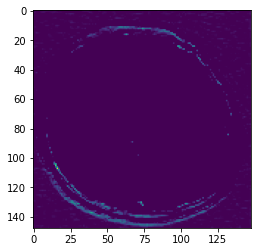

In [61]:
camadas_outputs = []
for layer in best_model.layers[:len(best_model.layers) - 4]:
    print(layer.output.shape)
    camadas_outputs.append(layer.output)

# e depois criamos um modelo que retorna estes outputs dado os inputs do modelo
activation_model = Model(inputs=best_model.input, outputs=camadas_outputs) 
activations = activation_model.predict(imagem_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.imshow(first_layer_activation[0, :, :, 9], cmap='viridis')
plt.show()

Nome da camada:  conv2d_251
Nome da camada:  max_pooling2d_251
Nome da camada:  conv2d_252
Nome da camada:  max_pooling2d_252
Nome da camada:  dropout_251
Nome da camada:  conv2d_253
Nome da camada:  max_pooling2d_253
Nome da camada:  dropout_252
nome_camada: conv2d_251
n_features: 64
size: 148
n_linhas: 2
nome_camada: max_pooling2d_251
n_features: 64
size: 74
n_linhas: 2
nome_camada: conv2d_252
n_features: 128
size: 72
n_linhas: 2
nome_camada: max_pooling2d_252
n_features: 128
size: 36
n_linhas: 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


nome_camada: dropout_251
n_features: 128
size: 36
n_linhas: 2
nome_camada: conv2d_253
n_features: 128
size: 34
n_linhas: 2
nome_camada: max_pooling2d_253
n_features: 128
size: 17
n_linhas: 2
nome_camada: dropout_252
n_features: 128
size: 17
n_linhas: 2


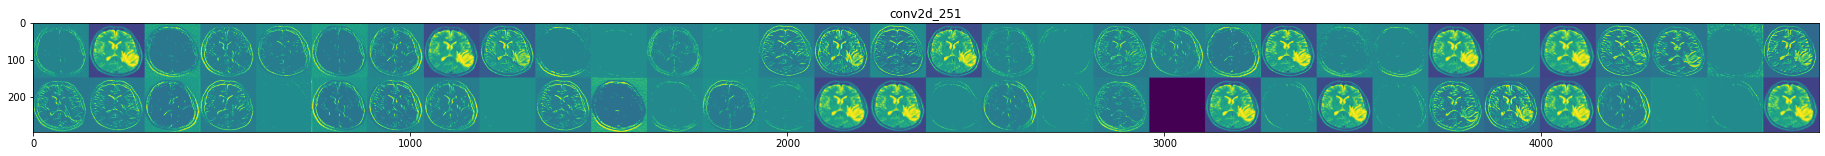

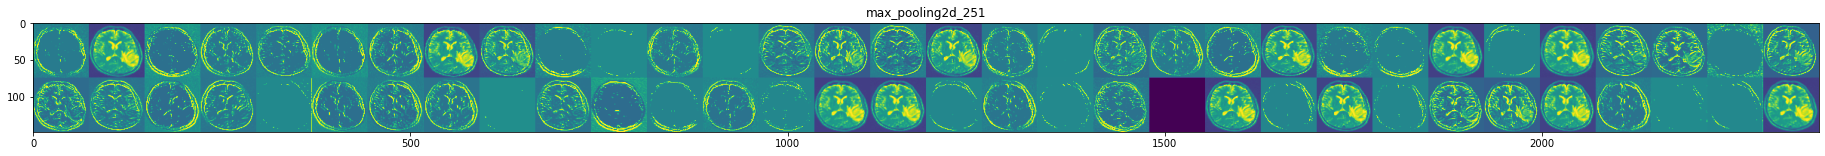

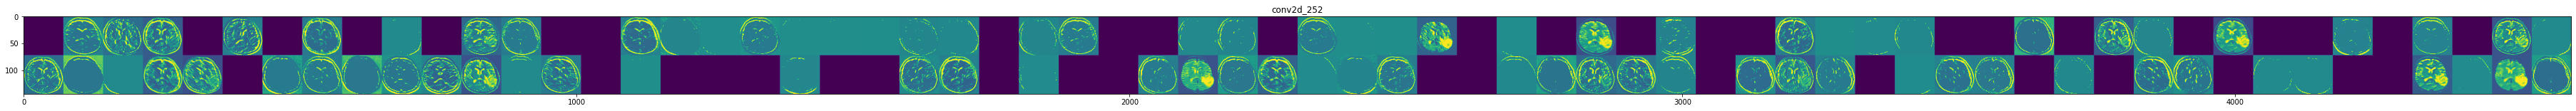

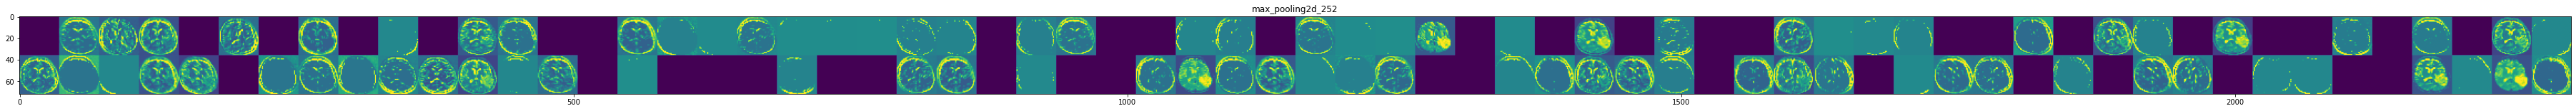

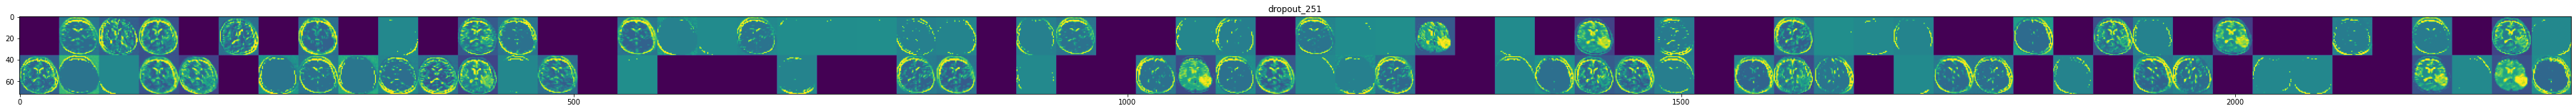

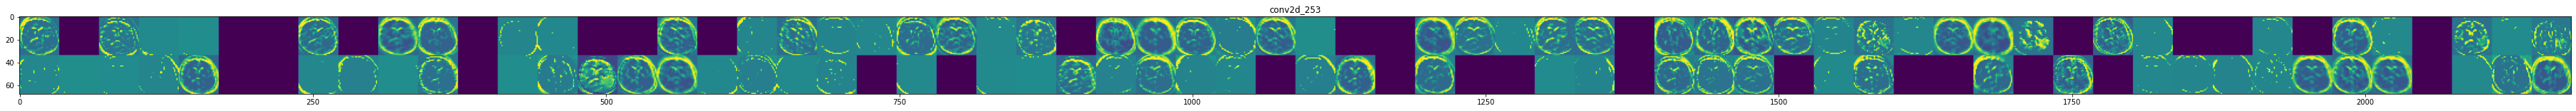

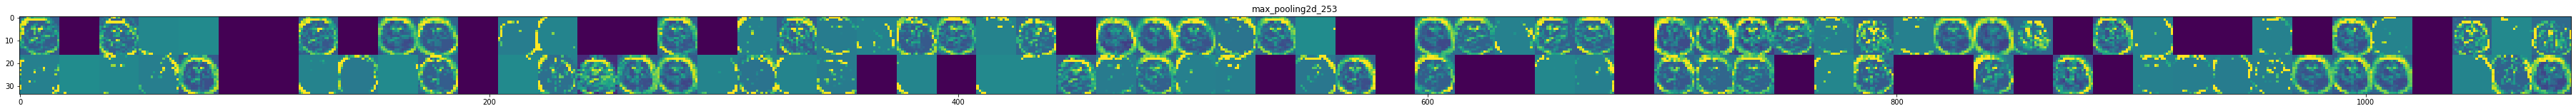

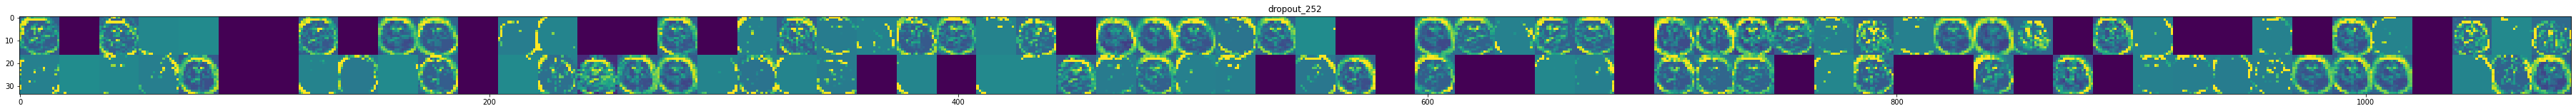

In [62]:
nome_camadas = []
for camada in best_model.layers[:len(best_model.layers) - 4]:
    print("Nome da camada: ", camada.name)
    nome_camadas.append(camada.name)

for nome_camada, ativacao_camada in zip(nome_camadas, activations): # o zip permite iterar simultaneamente em 2 listas
    n_features = ativacao_camada.shape[-1] # Numero de features no feature map, pois é o que está na ultima dimensão
    imagens_por_linha = int(n_features / 2)
    size = ativacao_camada.shape[1] #O feature map tem shape (1, tamanho, tamanho, numero_features).
    n_linhas = -(-n_features // imagens_por_linha) # Empilha os canais de ativação nesta matriz
    print("nome_camada:",nome_camada)
    print("n_features:",n_features)
    print("size:",size)
    print("n_linhas:",n_linhas)
    display_grid = np.zeros((size * n_linhas, imagens_por_linha * size))
    for col in range(n_linhas): 
        for lin in range(imagens_por_linha):
            #verificar aqui se a imagem existe
            imagem = ativacao_camada[0,:,:,col * imagens_por_linha + lin] #isto pode dar erro de out-of-range
            imagem -= imagem.mean() # pos-processamento para melhor visualização
            imagem /= imagem.std()
            imagem *= 64
            imagem += 128
            imagem = np.clip(imagem, 0, 255).astype('uint8') #valores <0 ficam 0 e >255 ficam = 255
            display_grid[col * size : (col + 1) * size,lin * size : (lin + 1) * size] = imagem
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(nome_camada)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')        

